<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/notebooks/CNN_VGG_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL NETWORK BUILD

# 1. LIbrary Import

In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import csv
import shutil
import json
from sklearn import metrics as skmet
from skimage import morphology
from skimage import measure
from skimage import exposure

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

# 2. Module Fuction

##2.1. keras application VGG16

In [2]:
from tensorflow.keras.applications import VGG16
model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

## 2.2. Conv Block & Output Block Define 

In [3]:
def conv_block_2d(lr_conv, lr_num, par_list, bkn):
        # parameter
        filter_num = par_list[0]
        conv_size = par_list[1]
        conv_act = par_list[2]
        pool_size = par_list[3]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filter_num, conv_size, activation=None, padding='same', 
                                    kernel_initializer='he_normal',
                                    name='block{}_conv{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='block{}_batchnorm{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.Activation(conv_act, name='block{}_activ{}'.format(bkn, i+1))(lr_conv)
        lr_pool = layers.MaxPooling2D(pool_size=pool_size, name='block{}_pool'.format(bkn, i+1))(lr_conv)
        return lr_pool

def conv_block_3d(lr_conv, lr_num, par_list, bkn):
        # parameter
        filter_num = par_list[0]
        conv_size = par_list[1]
        conv_act = par_list[2]
        pool_size = par_list[3]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv3D(filter_num, conv_size, activation=None, padding='same', 
                                    kernel_initializer='he_normal',
                                    name='block{}_conv{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='block{}_batchnorm{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.Activation(conv_act, name='block{}_activ{}'.format(bkn, i+1))(lr_conv)
        lr_pool = layers.MaxPooling3D(pool_size=pool_size, name='block{}_pool'.format(bkn, i+1))(lr_conv)
        return lr_pool

def output_block(lr_dense, block_num, dens_count, act_func, drop_rate):
    lr_dense = layers.Flatten(name='flatten_layer')(lr_dense)
    for i in range(block_num):
        lr_dense = layers.Dense(dens_count[i], kernel_regularizer=None,
                                activation=act_func, name='classifier_dense_{}'.format(i+1))(lr_dense)
        lr_dense = layers.Dropout(drop_rate, name='classifier_dropout_{}'.format(i+1))(lr_dense)
    return lr_dense

## 2.3. VGG16 Build(2D & 3D)

In [4]:
def VGG16_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1), name='input_layer')
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size])
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size])
    block3 = conv_block_2d(block2, 3, [256, conv_size, conv_act, pool_size])
    block4 = conv_block_2d(block3, 3, [512, conv_size, conv_act, pool_size])
    block5 = conv_block_2d(block4, 3, [512, conv_size, conv_act, pool_size])
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act, name='output_layer')(dens)
    model = Model(inputs, outputs)
    return model

In [18]:
def VGG16_3D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, input_size, 1), name='input_layer')
    block1 = conv_block_3d(inputs, 2, [64, conv_size, conv_act, pool_size])
    block2 = conv_block_3d(block1, 2, [128, conv_size, conv_act, pool_size])
    block3 = conv_block_3d(block2, 3, [256, conv_size, conv_act, pool_size])
    block4 = conv_block_3d(block3, 3, [512, conv_size, conv_act, pool_size])
    block5 = conv_block_3d(block4, 3, [512, conv_size, conv_act, pool_size])
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act, name='output_layer')(dens)
    model = Model(inputs, outputs)
    return model

## 2.4. VGG19 Build (2D & 3D)

In [6]:
def VGG19_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1))
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_2d(block2, 4, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_2d(block3, 4, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_2d(block4, 4, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

In [19]:
def VGG19_3D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, input_size, 1))
    block1 = conv_block_3d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_3d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_3d(block2, 4, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_3d(block3, 4, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_3d(block4, 4, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

# 3. Dataset

In [8]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


# 3.1 2D dataset

In [10]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:5000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(5000, 32, 32, 1) (500, 32, 32, 1)


In [11]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:5000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(5000, 10) (500, 10)


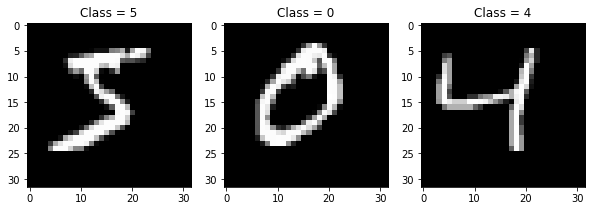

In [12]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

## 3.2 3D dataset

In [13]:
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
for i in range(1200):
    zero = np.zeros(shape=(32,32,32))
    ones = np.ones(shape=(16,16,16))
    ran = int(np.random.randint(10, size=1)-5)
    if 0 <= i < 400:
        zero[:,:,:] = (ran*10) + 150
        x_train_list.append(zero)
        y_train_list.append([1,0,0])
    elif 400 <= i < 800:
        zero[8+ran:24+ran,8+ran:24+ran,8+ran:24+ran] = (ran*10) + 200
        x_train_list.append(zero)
        y_train_list.append([0,1,0])
    elif 800 <= i < 1200:
        for j in range(32):
            for k in range(32):
                for l in range(32):
                    if ((j-16+ran)**2) + ((k-16+ran)**2) + ((l-16+ran)**2) < 100:
                        zero[j,k,l] = (ran*10) + 200
        x_train_list.append(zero)
        y_train_list.append([0,0,1])

for i in range(600):
    zero = np.zeros(shape=(32,32,32))
    ones = np.ones(shape=(16,16,16))
    ran = int(np.random.randint(10, size=1)-5)
    if 0 <= i < 200:
        zero[:,:,:] = (ran*10) + 150
        x_test_list.append(zero)
        y_test_list.append([1,0,0])
    elif 200 <= i < 400:
        zero[8+ran:24+ran,8+ran:24+ran,8+ran:24+ran] = (ran*10) + 200
        x_test_list.append(zero)
        y_test_list.append([0,1,0])
    elif 400 <= i < 600:
        for j in range(32):
            for k in range(32):
                for l in range(32):
                    if ((j-16+ran)**2) + ((k-16+ran)**2) + ((l-16+ran)**2) < 100:
                        zero[j,k,l] = (ran*10) + 200
        x_test_list.append(zero)
        y_test_list.append([0,0,1])

x3_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x3_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
y3_train1 = np.array(y_train_list)
y3_test1 = np.array(y_test_list)
print(x3_train1.shape, x3_test1.shape)
print(y3_train1.shape, y3_test1.shape)

(1200, 32, 32, 32, 1) (600, 32, 32, 32, 1)
(1200, 3) (600, 3)


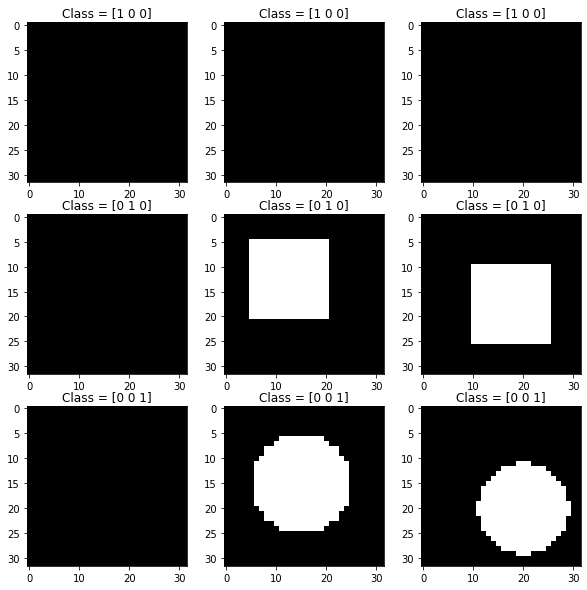

In [14]:
plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, (3*i)+j+1)
        plt.imshow(x3_train1[(i*400)+(j*100)][(8*j)+8,...,0], cmap='gray')
        plt.title('Class = {}'.format(str(y3_train1[(i*400)+(j*100)])))


# 3. Model Build

## 3.1 2D

In [15]:
network_param_2d = {'input_size': 32,
                     'conv_size': 3,
                     'conv_act': 'relu',
                     'pool_size': 2,
                     'dens_num': 2,
                     'dens_count': [1000,500],
                     'dens_act': 'relu',
                     'drop_out': 0.5,
                     'output_count': 10,
                     'output_act': 'softmax'}

In [16]:
model = VGG19_2D(network_param_2d)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_batchnorm1 (BatchNorm (None, 32, 32, 64)        256       
_________________________________________________________________
block1_activ1 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_batchnorm2 (BatchNorm (None, 32, 32, 64)        256       
_________________________________________________________________
block1_activ2 (Activation)   (None, 32, 32, 64)        0     

In [ ]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])


In [ ]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('2d_model.h5'),
                                                         monitor='val_accuracy', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]

history = model.fit(x_train1, y_train1, epochs=50, batch_size=32, 
                    validation_data=(x_test1, y_test1),
                    callbacks=callback_list, shuffle=True)

Epoch 1/50
148/157 [===========================>..] - ETA: 26s - loss: 3.8944 - acc: 0.2021

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
# Accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, acc, 'b', label='Training acc = {}%'.format(np.around(np.max(acc) * 100, decimals=1)))
plt.plot(epochs, val_acc, 'r', label='Validation acc = {}%'.format(np.around(np.max(val_acc) * 100, decimals=1)))
plt.title('{} Accuracy (Total Epoch = {})'.format('VGG16', len(acc)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()
# Loss graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'b', label='Training loss = {}'.format(np.around(np.min(loss), decimals=3)))
plt.plot(epochs, val_loss, 'r', label='Validation loss= {}'.format(np.around(np.min(val_loss), decimals=3)))
plt.title('{} Loss (Total Epoch = {})'.format('VGG16', len(loss)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()

## 3.2 3D 

In [20]:
network_param_3d = {'input_size': 32,
                     'conv_size': 3,
                     'conv_act': 'relu',
                     'pool_size': 2,
                     'dens_num': 2,
                     'dens_count': [1000,500],
                     'dens_act': 'relu',
                     'drop_out': 0.5,
                     'output_count': 3,
                     'output_act': 'softmax'}

In [21]:
model = VGG19_3D(network_param_3d)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
block1_conv1 (Conv3D)        (None, 32, 32, 32, 64)    1792      
_________________________________________________________________
block1_batchnorm1 (BatchNorm (None, 32, 32, 32, 64)    256       
_________________________________________________________________
block1_activ1 (Activation)   (None, 32, 32, 32, 64)    0         
_________________________________________________________________
block1_conv2 (Conv3D)        (None, 32, 32, 32, 64)    110656    
_________________________________________________________________
block1_batchnorm2 (BatchNorm (None, 32, 32, 32, 64)    256       
_________________________________________________________________
block1_activ2 (Activation)   (None, 32, 32, 32, 64)    0   

In [23]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])
callback_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=12),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('3d_model.h5'),
                                                         monitor='val_accuracy', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]

history = model.fit(x3_train1, y3_train1, epochs=100, batch_size=32, 
                    validation_data=(x3_test1, y3_test1),
                    callbacks=callback_list, shuffle=True)

Epoch 1/100
 5/38 [==>...........................] - ETA: 25s - loss: 0.0925 - acc: 0.9622

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
# Accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, acc, 'b', label='Training acc = {}%'.format(np.around(np.max(acc) * 100, decimals=1)))
plt.plot(epochs, val_acc, 'r', label='Validation acc = {}%'.format(np.around(np.max(val_acc) * 100, decimals=1)))
plt.title('{} Accuracy (Total Epoch = {})'.format('VGG16', len(acc)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()
# Loss graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'b', label='Training loss = {}'.format(np.around(np.min(loss), decimals=3)))
plt.plot(epochs, val_loss, 'r', label='Validation loss= {}'.format(np.around(np.min(val_loss), decimals=3)))
plt.title('{} Loss (Total Epoch = {})'.format('VGG16', len(loss)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()

# 4. Additional Model

# 4.1 VGG19

* keras application

In [ ]:
from tensorflow.keras.applications import VGG19
model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()

In [ ]:
def VGGfree_2D(input_size, block_num, layer_num, drop_out, flat_count, class_count, conv_act, flat_act, output_act, conv_str, pool_str):

    inputs = Input(shape=(input_size, input_size, 1))
    block = layers.Conv2D(32, conv_str, activation=conv_act, padding='same', kernel_initializer='he_normal')(inputs)
    for i in range(block_num):
        block = cn.conv_block_2d(block, layer_num, [32*(2**i), conv_str, conv_act, pool_str, drop_out])
    flat = layers.Flatten()(block)
    drop1 = layers.Dropout(drop_out)(flat)
    dens = layers.Dense(flat_count, activation=flat_act)(drop1)
    drop2 = layers.Dropout(drop_out)(dens)
    outputs = layers.Dense(class_count, activation=output_act)(drop2)
    model = Model(inputs, outputs)
    return model

model = VGGfree_2D(32, 5, 2, 0.5, 256, 2, 'relu', 'relu', 'sigmoid', 3, 2)
model.summary()